# FullClass-TrainCNN(InceptionV3)_NoFreezModel_ClassImbalance-byManualCopyingOversampling

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

## Testing Set DIR

In [3]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [4]:
img_height=299
img_width=299
batch_size=64

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [6]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [8]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [9]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [10]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


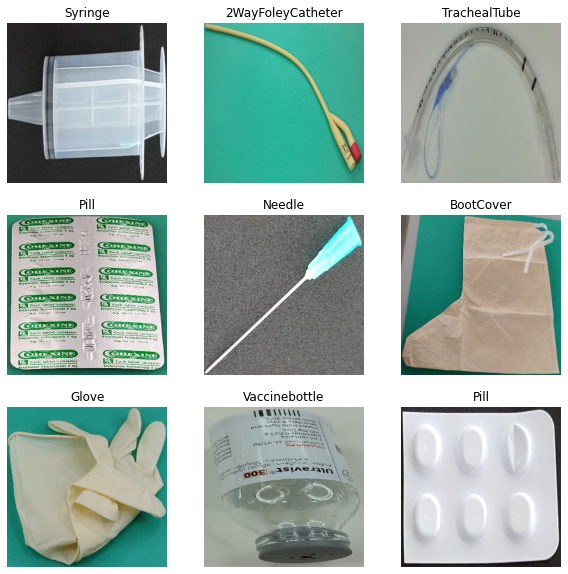

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
model = tf.keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Class Weight

In [20]:
y_train = np.concatenate([ y for x,y in train_ds],axis=0)

[26 21 39 ...  2 26 19]


In [22]:
print(len(y_train))
print(y_train)

3095
[26 21 39 ...  2 26 19]


In [27]:
######################### Class Weight
from sklearn.utils import class_weight

# compute class weight 
# based on appearance of each class in y_trian
class_weight_value = class_weight.compute_class_weight(class_weight='balanced', classes=sorted(np.unique(y_train)), y=y_train)
# dict mapping
class_weight_value = {i : class_weight_value[i] for i, label in enumerate(sorted(np.unique(y_train)))}

In [28]:
print(class_weight_value)

{0: 5.806754221388368, 1: 2.220229555236729, 2: 2.040210942649967, 3: 4.193766937669377, 4: 1.9355847404627893, 5: 0.5510058750222538, 6: 4.440459110473458, 7: 2.156794425087108, 8: 2.287509238728751, 9: 1.9865211810012837, 10: 4.193766937669377, 11: 3.2820784729586427, 12: 2.695993031358885, 13: 2.156794425087108, 14: 3.9730423620025674, 15: 3.59465737514518, 16: 0.39730423620025673, 17: 4.717987804878049, 18: 0.3931656504065041, 19: 0.2755029375111269, 20: 1.451688555347092, 21: 1.3243474540008557, 22: 0.3682331945270672, 23: 1.5726626016260163, 24: 1.7555303460011344, 25: 0.46029149315883405, 26: 0.11685418711772257, 27: 0.9932605905006419, 28: 2.7958446251129176, 29: 4.440459110473458, 30: 2.516260162601626, 31: 1.0065040650406505, 32: 4.193766937669377, 33: 4.193766937669377, 34: 1.6061235080435912, 35: 2.516260162601626, 36: 0.5278867473989425, 37: 3.9730423620025674, 38: 3.774390243902439, 39: 0.6739982578397212, 40: 2.4350904799370574}


In [29]:
EPOCHS = 400
checkpoint_filepath = 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight/ClassImbalancedByClassWeight-epoch{epoch:03d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    class_weight=class_weight_value
    )

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback]) 

Epoch 1/400
49/49 [==============================] - 51s 755ms/step - loss: 1.4478 - accuracy: 0.6572 - val_loss: 3.6652 - val_accuracy: 0.1527
INFO:tensorflow:Assets written to: D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\ClassImbalancedByClassWeight-epoch001-val_acc0.15.pb\assets
Epoch 2/400
49/49 [==============================] - 27s 556ms/step - loss: 0.4045 - accuracy: 0.8821 - val_loss: 3.1192 - val_accuracy: 0.3558
INFO:tensorflow:Assets written to: D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\ClassImbalancedByClassWeight-epoch002-val_acc0.36.pb\assets
Epoch 3/400
49/49 [==============================] - 28s 555ms/step - loss: 0.2808 - accuracy: 0.9089 - val_loss: 8.9799 - val_accuracy: 0.1190
INFO:tensorflow:Assets written to: D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\ClassImbalancedByClassWeight-epoch003-val_acc0.12.pb\assets
Epoch 4/400
49/49 [==============================] - 27s 555ms/step - loss: 0.1809 - accuracy: 0.9438 -

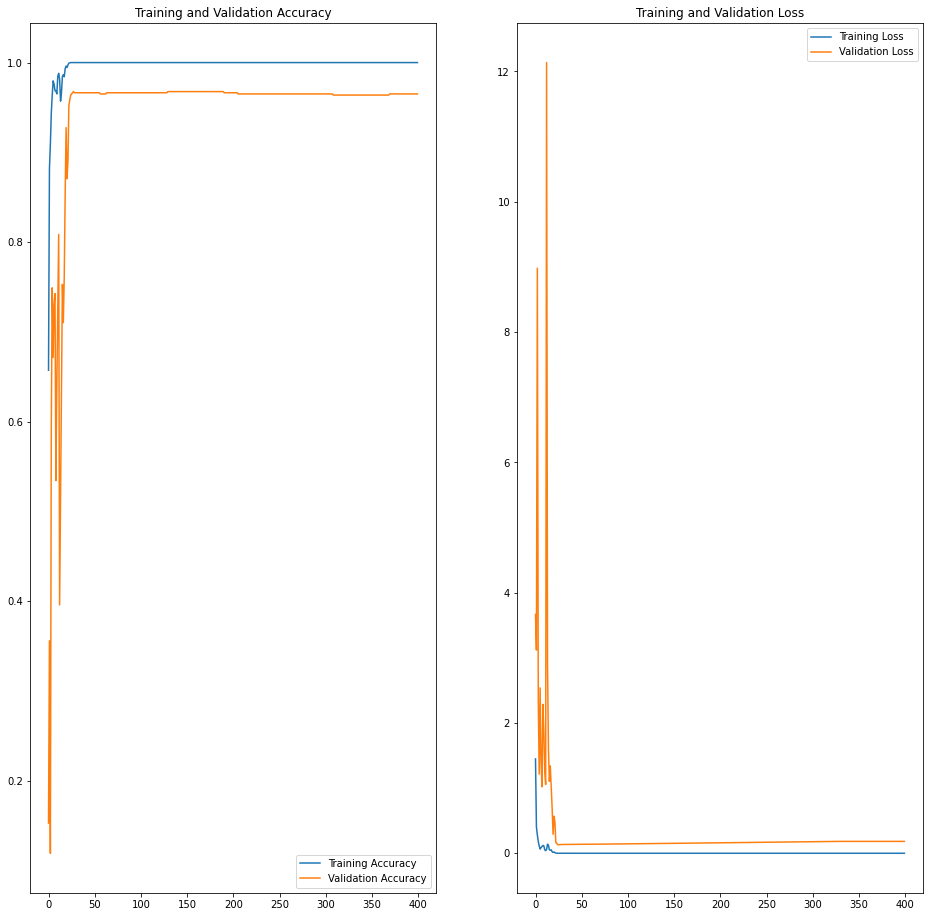

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 348ms/step - loss: 3.2063 - accuracy: 0.5713
test_indoor_ds_results:test loss, test acc: [3.2062737941741943, 0.5713489651679993]


In [32]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 440ms/step - loss: 3.3098 - accuracy: 0.5962
test_outdoor_ds_results:test loss, test acc: [3.309812307357788, 0.5961783528327942]


In [33]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 206ms/step - loss: 1.6528 - accuracy: 0.7675
test_belt_ds_results:test loss, test acc: [1.652761697769165, 0.7674524188041687]


In [34]:
# Read path of trained model
import os, os.path
trained_path = 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight'
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths


['D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\\ClassImbalancedByClassWeight-epoch001-val_acc0.15.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\\ClassImbalancedByClassWeight-epoch002-val_acc0.36.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\\ClassImbalancedByClassWeight-epoch003-val_acc0.12.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\\ClassImbalancedByClassWeight-epoch004-val_acc0.60.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\\ClassImbalancedByClassWeight-epoch005-val_acc0.75.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\\ClassImbalancedByClassWeight-epoch006-val_acc0.67.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\\ClassImbalancedByClassWeight-epoch007-val_acc0.73.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight\\ClassImbalancedByClassWeight-epoch008-val_acc0.74.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassW

In [35]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []
for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    print(f"Epoch{lm_idx+1:02d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 139ms/step - loss: 4.1725 - accuracy: 0.0816
Epoch01 
 test_indoor_acc=0.036231882870197296 
 test_outdoor_acc=0.10668789595365524 
 test_belt_acc=0.08159565180540085
35/35 [==============================] - 5s 138ms/step - loss: 3.8310 - accuracy: 0.2239
Epoch02 
 test_indoor_acc=0.174470454454422 
 test_outdoor_acc=0.24012738466262817 
 test_belt_acc=0.22393472492694855
35/35 [==============================] - 5s 141ms/step - loss: 9.9823 - accuracy: 0.0898
Epoch03 
 test_indoor_acc=0.03400222957134247 
 test_outdoor_acc=0.09777069836854935 
 test_belt_acc=0.08975521475076675
35/35 [==============================] - 5s 143ms/step - loss: 5.0725 - accuracy: 0.3867
Epoch04 
 test_indoor_acc=0.13154961168766022 
 test_outdoor_acc=0.33343949913978577 
 test_belt_acc=0.386672705411911
35/35 [==============================] - 5s 140ms/step - loss: 2.4385 - accuracy: 0.5227
Epoch05 
 test_indoor_acc=0.23578594624996185 
 test_outdoor_acc=0.4047770

Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

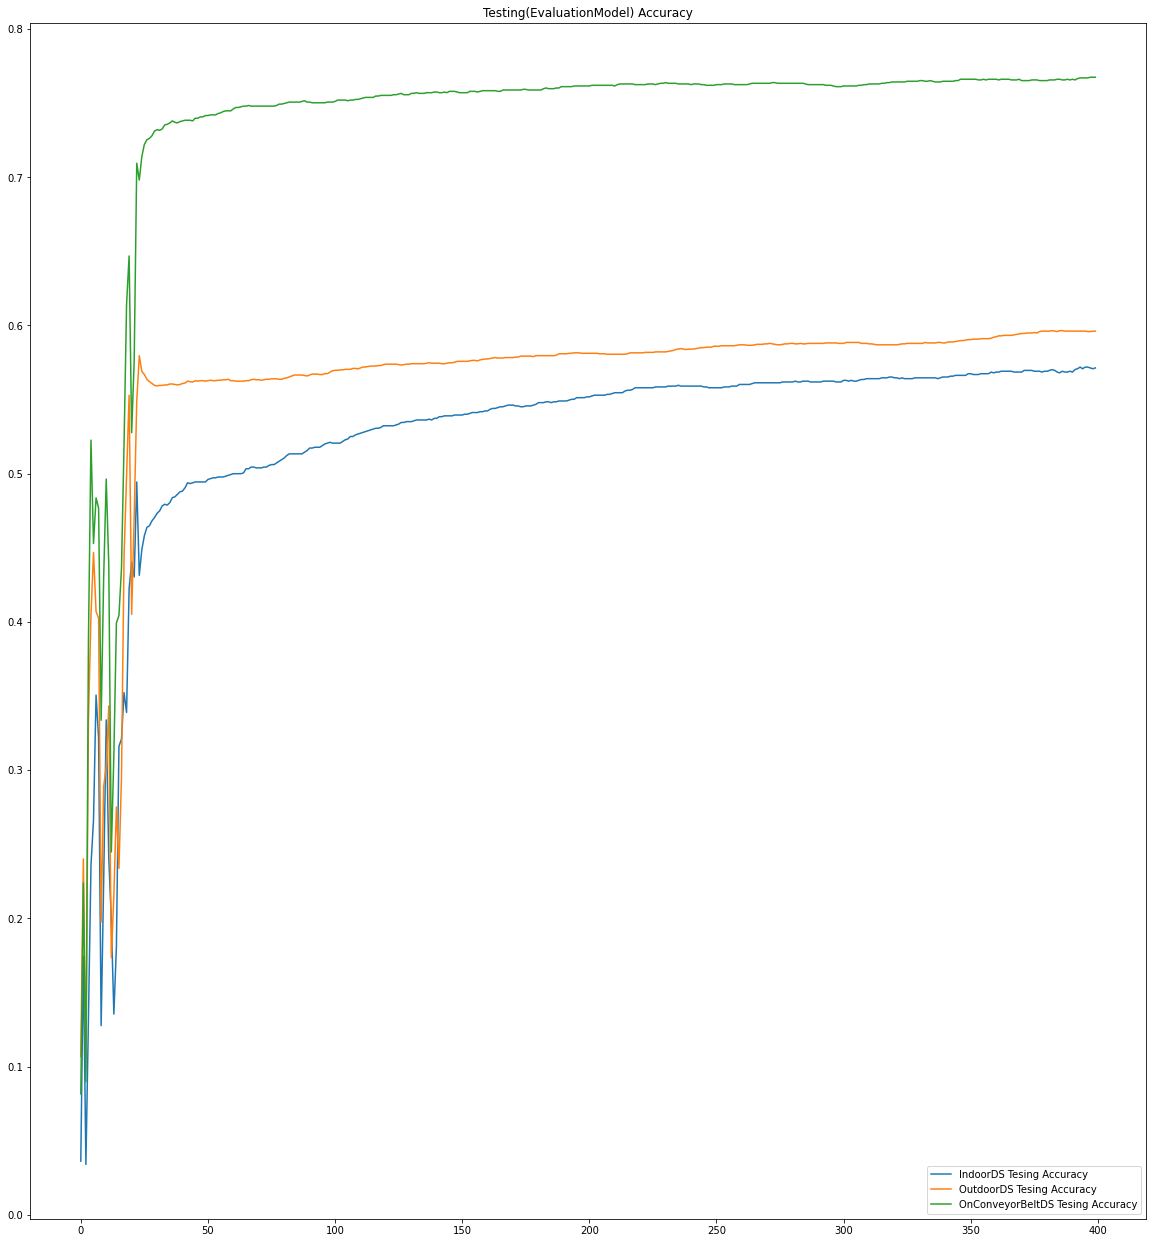

In [36]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')



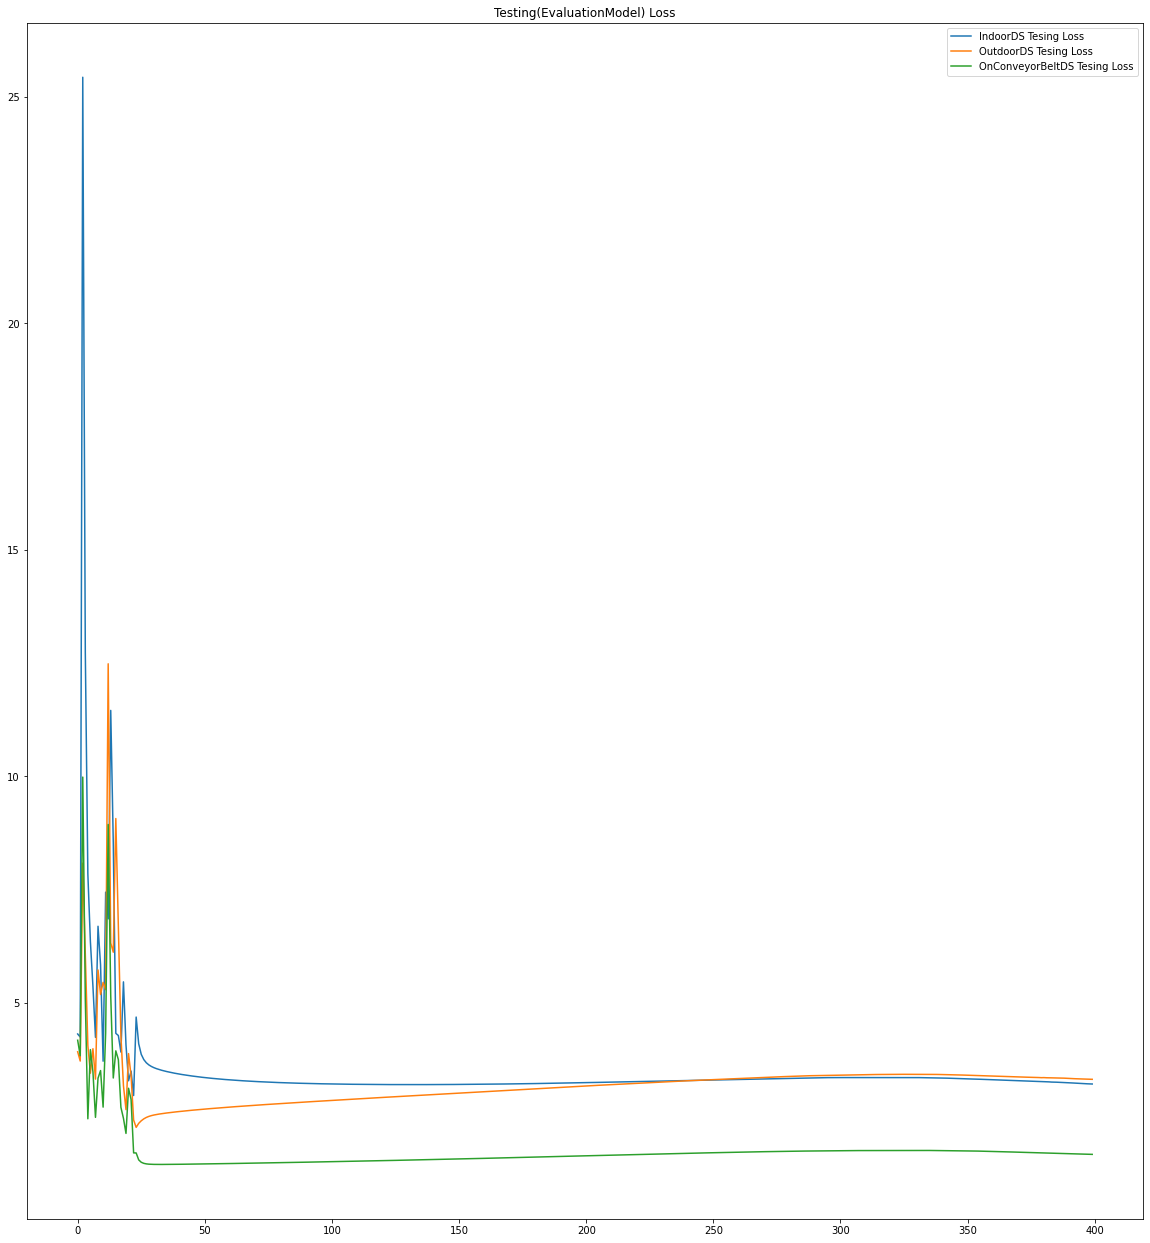

In [37]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [38]:
test_indoor_acc

[0.036231882870197296,
 0.174470454454422,
 0.03400222957134247,
 0.13154961168766022,
 0.23578594624996185,
 0.2664436995983124,
 0.35061314702033997,
 0.3216276466846466,
 0.12764771282672882,
 0.22575250267982483,
 0.33389073610305786,
 0.24080267548561096,
 0.1989966481924057,
 0.1354515105485916,
 0.18060201406478882,
 0.31605350971221924,
 0.32107022404670715,
 0.35228538513183594,
 0.33890748023986816,
 0.4225195050239563,
 0.4403567314147949,
 0.4303233027458191,
 0.49442586302757263,
 0.4314381182193756,
 0.44871795177459717,
 0.45819398760795593,
 0.4637681245803833,
 0.4648829400539398,
 0.46822741627693176,
 0.4704570770263672,
 0.47324416041374207,
 0.47491639852523804,
 0.47826087474823,
 0.4793756902217865,
 0.47881829738616943,
 0.4804905354976654,
 0.48383501172065735,
 0.4843924045562744,
 0.4860646724700928,
 0.48773691058158875,
 0.4882943034172058,
 0.49052396416664124,
 0.4938684403896332,
 0.4933110475540161,
 0.4938684403896332,
 0.49442586302757263,
 0.49442586

In [39]:
test_outdoor_acc

[0.10668789595365524,
 0.24012738466262817,
 0.09777069836854935,
 0.33343949913978577,
 0.40477707982063293,
 0.44681528210639954,
 0.4070063829421997,
 0.40254777669906616,
 0.19745223224163055,
 0.28917196393013,
 0.30222928524017334,
 0.3433121144771576,
 0.17356687784194946,
 0.21560509502887726,
 0.27515923976898193,
 0.23375795781612396,
 0.2952229380607605,
 0.443630576133728,
 0.4977706968784332,
 0.5528662204742432,
 0.40509554743766785,
 0.47133758664131165,
 0.5490446090698242,
 0.5796178579330444,
 0.5691083073616028,
 0.5668789744377136,
 0.5636942386627197,
 0.5621019005775452,
 0.5608280301094055,
 0.5595541596412659,
 0.559235692024231,
 0.5595541596412659,
 0.5595541596412659,
 0.5598726272583008,
 0.5598726272583008,
 0.5605095624923706,
 0.5605095624923706,
 0.5601910948753357,
 0.5598726272583008,
 0.5601910948753357,
 0.5608280301094055,
 0.5611464977264404,
 0.5624203681945801,
 0.5621019005775452,
 0.5617834329605103,
 0.562738835811615,
 0.5624203681945801,
 0.

In [40]:
test_belt_acc

[0.08159565180540085,
 0.22393472492694855,
 0.08975521475076675,
 0.386672705411911,
 0.5226654410362244,
 0.4528558552265167,
 0.4836808741092682,
 0.4768812358379364,
 0.333635538816452,
 0.4306437075138092,
 0.4963735342025757,
 0.4388032555580139,
 0.24478694796562195,
 0.3100634515285492,
 0.3993653655052185,
 0.40435177087783813,
 0.4360834062099457,
 0.5194922685623169,
 0.6142339110374451,
 0.6468721628189087,
 0.527651846408844,
 0.5766092538833618,
 0.7094288468360901,
 0.6980960965156555,
 0.7139618992805481,
 0.7221214771270752,
 0.7252946496009827,
 0.7262012958526611,
 0.7280145287513733,
 0.731187641620636,
 0.7320942878723145,
 0.7316409945487976,
 0.7325475811958313,
 0.7352674603462219,
 0.7357207536697388,
 0.7366273999214172,
 0.7379872798919678,
 0.7370806932449341,
 0.7366273999214172,
 0.7375339865684509,
 0.7379872798919678,
 0.7384406328201294,
 0.7384406328201294,
 0.7384406328201294,
 0.7379872798919678,
 0.7398005723953247,
 0.7398005723953247,
 0.740707159

In [41]:
test_indoor_loss

[4.310659408569336,
 4.242753982543945,
 25.432296752929688,
 12.74100399017334,
 7.847863674163818,
 6.350804328918457,
 5.3643269538879395,
 4.235915660858154,
 6.6884918212890625,
 5.833650588989258,
 3.709883213043213,
 7.441407203674316,
 6.8511786460876465,
 11.45373821258545,
 8.536911964416504,
 4.32466459274292,
 4.2762370109558105,
 3.9114339351654053,
 5.461075305938721,
 4.066972255706787,
 3.277445077896118,
 3.4908206462860107,
 2.9514949321746826,
 4.683919429779053,
 4.093654632568359,
 3.861112117767334,
 3.7455406188964844,
 3.6746835708618164,
 3.6275508403778076,
 3.593125581741333,
 3.566549301147461,
 3.544689655303955,
 3.5260910987854004,
 3.509744644165039,
 3.4949965476989746,
 3.4813361167907715,
 3.4688055515289307,
 3.4569318294525146,
 3.445709705352783,
 3.435199022293091,
 3.425368070602417,
 3.415801525115967,
 3.40698504447937,
 3.3982784748077393,
 3.3900671005249023,
 3.38240385055542,
 3.3748626708984375,
 3.3675928115844727,
 3.360762357711792,
 3.

In [42]:
test_outdoor_loss

[3.9178617000579834,
 3.7130186557769775,
 8.082304000854492,
 6.076092720031738,
 4.058315277099609,
 3.4447739124298096,
 3.9851577281951904,
 3.3146462440490723,
 5.724156379699707,
 5.182002544403076,
 5.45079231262207,
 5.289440155029297,
 12.48314380645752,
 6.317906379699707,
 6.115577220916748,
 9.06682300567627,
 6.639981746673584,
 4.278911590576172,
 3.169368267059326,
 2.640354633331299,
 3.8772060871124268,
 3.3888158798217773,
 2.4110772609710693,
 2.248842716217041,
 2.3377840518951416,
 2.3941822052001953,
 2.436755895614624,
 2.4681406021118164,
 2.491027355194092,
 2.508171558380127,
 2.5218183994293213,
 2.5328431129455566,
 2.5423762798309326,
 2.5510926246643066,
 2.558964252471924,
 2.5662741661071777,
 2.573410987854004,
 2.580162525177002,
 2.5867080688476562,
 2.592963695526123,
 2.599045991897583,
 2.604921817779541,
 2.6107261180877686,
 2.616368293762207,
 2.6217844486236572,
 2.627168655395508,
 2.632394552230835,
 2.6375949382781982,
 2.642603874206543,
 2

In [43]:
test_belt_loss

[4.172488689422607,
 3.8309662342071533,
 9.982254028320312,
 5.07248067855835,
 2.438464641571045,
 3.9652223587036133,
 3.477808713912964,
 2.4701271057128906,
 3.3345823287963867,
 3.503201723098755,
 2.6957714557647705,
 4.331973552703857,
 8.93527603149414,
 5.150916576385498,
 3.339020252227783,
 3.938352108001709,
 3.7450475692749023,
 2.691568613052368,
 2.4496593475341797,
 2.115285634994507,
 3.112056255340576,
 2.8648746013641357,
 1.685348629951477,
 1.6838968992233276,
 1.5312693119049072,
 1.4785077571868896,
 1.4546295404434204,
 1.4427082538604736,
 1.4364752769470215,
 1.4332270622253418,
 1.4315646886825562,
 1.4307365417480469,
 1.4304167032241821,
 1.4304834604263306,
 1.430734395980835,
 1.4311113357543945,
 1.4315659999847412,
 1.4320794343948364,
 1.4326778650283813,
 1.4332635402679443,
 1.433933138847351,
 1.434610366821289,
 1.435329556465149,
 1.436078667640686,
 1.4368170499801636,
 1.4375834465026855,
 1.438381552696228,
 1.4391679763793945,
 1.440006136894

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model('E:/ModelMedicalWasteCheckpoint/ClassImbalancedByClassWeight/ClassImbalancedByClassWeight-epoch400-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_train_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_train_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_train_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_train_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_train_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_train_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_train_indoor)},{len(y_train_indoor)}")
print(f"train_outdoor num x,y : {len(x_train_outdoor)},{len(y_train_outdoor)}")
print(f"train_belt num x,y : {len(x_train_belt)},{len(y_train_belt)}")
x_all = np.concatenate([x_train_indoor,x_train_outdoor,x_train_belt],axis=0)
y_all = np.concatenate([y_train_indoor,y_train_outdoor,y_train_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [2]:
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=4590
FP=2550
acc=0.6428571428571429
all check = 7140


In [3]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')

1WayConnectorforFoley acc = 49.137931034482754%
2WayConnectorforFoley acc = 89.1156462585034%
2WayFoleyCatheter acc = 37.3134328358209%
3WayConnectorforFoley acc = 74.35897435897436%
3Waystopcock acc = 96.3963963963964%
AlcoholBottle acc = 81.25%
AlcoholPad acc = 30.158730158730158%
BootCover acc = 65.06024096385542%
CottonBall acc = 98.80239520958084%
CottonSwap acc = 39.16083916083916%
Dilator acc = 43.58974358974359%
DisposableInfusionSet acc = 45.13274336283185%
ExtensionTube acc = 28.455284552845526%
FaceShield acc = 50.617283950617285%
FrontLoadSyringe acc = 19.469026548672566%
GauzePad acc = 63.06818181818182%
Glove acc = 70.53571428571429%
GuideWire acc = 17.857142857142858%
LiquidBottle acc = 53.05343511450382%
Mask acc = 89.35064935064935%
NGTube acc = 41.29032258064516%
NasalCannula acc = 53.09734513274337%
Needle acc = 73.57142857142858%
OxygenMask acc = 54.88721804511278%
PPESuit acc = 75.80645161290323%
PharmaceuticalProduct acc = 75.46728971962617%
Pill acc = 95.37815126